# Data retrieval and plotting methods for ADSS in-situ protocol OCV->CA->OCV

In [2]:
# imports
import sys
import io
import json
import os
import pathlib
from functools import reduce
from copy import copy
from datetime import datetime, timedelta
from dateutil import tz

import pandas as pd
import numpy as np
import scipy as sp
import mendeleev
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from ruamel.yaml import YAML
from scipy.interpolate import griddata

import parse_icpms

sys.path.append("/mnt/j/repos/helao-async")
sys.path.append("/mnt/j/repos/helao-core/")
from helao.drivers.data.loaders import pgs3

pgs3.LOADER = pgs3.HelaoLoader("/mnt/k/users/hte/.credentials/helao_data_nb.env")
yaml = YAML(typ="safe")


## munging functions for returned query dataframe

In [3]:
def query(raw_query_str: str) -> pd.DataFrame:
    """Query HELAO API tables and return dataframe."""
    result = pgs3.LOADER.run_raw_query(raw_query_str)
    if result:
        return pd.DataFrame(result)
    return pd.DataFrame()


def get_info_local(plate_id: int) -> dict:
    """Return plate info file from J: drive as dict."""
    info_path = pathlib.Path(
        f"/mnt/j/hte_jcap_app_proto/plate/{plate_id}/{plate_id}.info"
    )
    if info_path.exists():
        yaml_dict = yaml.load(info_path)
        return yaml_dict
    print(f"{plate_id}.info was not found in hte_jcap_app_proto/plate/")
    return {}


def get_info_db(plate_id: int) -> dict:
    """Return plate info file from API DB as dict."""
    info_query = f"""
SET SEARCH_PATH = full_database;
SELECT
    details,
    label
FROM
    collection
WHERE
    true
    AND label = '{plate_id}'
LIMIT 1
"""
    info_result = query(info_query)
    if info_result.shape[0] > 0:
        return info_result.iloc[0].details
    else:
        return {}


def get_info(plate_id: int, local: bool = True) -> dict:
    """Return plate info file as dict."""
    if local:
        return get_info_local(plate_id)
    return get_info_db(plate_id)


def get_xrfs_comps(plate_id: int) -> pd.DataFrame:
    """Return all compositions in sample table for a given plate_id."""
    comp_query = f"""
SET SEARCH_PATH = full_database;
SELECT
    s.label,
    s.type,
    s.details,
    s.xrfs_composition,
    CAST (c.label AS INTEGER) as plate_id,
    c.type,
    c.screening_map_id
FROM
    sample s
    JOIN collection__sample cs on s.id = cs.sample_id
    JOIN collection c on c.id = cs.collection_id
WHERE
    true
    AND s.xrfs_composition IS NOT NULL
    AND c.label = '{plate_id}'
LIMIT 3000
"""
    result_df = query(comp_query)
    if result_df.shape[0] == 0:
        return pd.DataFrame()
    for det_key in ("x", "y", "code"):
        result_df[det_key] = result_df.details.apply(lambda x: x.get(det_key, -1))
    elements = reduce(
        lambda x, y: x | y, result_df.xrfs_composition.apply(lambda x: set(x.keys()))
    )
    els = [el for el in sorted(elements) if el != "missing_elements"]
    for el in els:
        result_df[el] = result_df.xrfs_composition.apply(lambda x: x.get(el, 0))
    result_df["sample_no"] = result_df.label.apply(lambda x: int(x.split("_")[-1]))
    return (
        result_df[["plate_id", "sample_no", "x", "y"] + els]
        .sort_values("sample_no")
        .reset_index(drop=True)
    )


def getpm(pmint) -> pd.DataFrame:
    """Get platemap dataframe from S3 bucket"""
    jb = pgs3.LOADER.res.Bucket("sync.j")
    mmaps = [
        x.key
        for x in jb.objects.filter(Prefix="hte_jcap_app_proto__unzipped/map")
        if x.key.endswith(".txt")
        and x.key.split("/")[-1].split("-")[0].lstrip("0") == f"{int(float(pmint)):d}"
    ]
    mobj = pgs3.LOADER.res.Object(bucket_name="sync.j", key=mmaps[0])
    mbytes = io.BytesIO(mobj.get()["Body"].read())
    lbuf = mbytes.readline()
    while not lbuf.decode("utf8").startswith("% Sample"):
        lbuf = mbytes.readline()
    cols = [
        x.strip().split("(")[0].replace("% ", "")
        for x in lbuf.decode("utf8").strip().split(",")
    ]
    mdf = pd.read_csv(mbytes, names=cols)
    return mdf


PM57 = getpm(57)


def get_comp(plate_id: int, sample_no: int) -> dict:
    """Return interpolated composition for given plate_id and sample_no."""
    xdf = get_xrfs_comps(plate_id)
    if not xdf.shape[0] > 0:
        return {}
    els = [x for x in xdf.columns if x not in ("plate_id", "sample_no", "x", "y")]
    compdf = pd.DataFrame({"sample_no": sorted(set([sample_no]))})
    compdf = PM57.merge(compdf, left_on="Sample", right_on="sample_no")[
        ["Sample", "x", "y"]
    ]
    compd = {}
    for el in els:
        compval = griddata(
            xdf[["x", "y"]].to_numpy(),
            xdf[el].to_numpy(),
            compdf[["x", "y"]].to_numpy(),
            method="linear",
        )[0]
        compdf[el] = compval
        compd[el] = compval
    return compd


## munging functions for returned query dataframe

In [4]:
def extract_parts(action_uuid: str, sample_type: str, result_df: pd.DataFrame) -> str:
    """Parse assembly parts from samples_in and return global_label for matching sample_type."""
    ha = pgs3.HelaoAction(action_uuid, result_df)
    meta = ha.json
    assembly = [
        x for x in meta.get("samples_in", []) if x.get("sample_type", "") == "assembly"
    ]
    parts = assembly[0].get("parts", []) if assembly else []
    part = [x for x in parts if x.get("sample_type", "") == sample_type]
    global_label = part[0]["global_label"] if part else None
    return global_label


def extract_samples_out(action_uuid: str, result_df: pd.DataFrame) -> str:
    """Parse samples_out and return global_label for sample_type=='liquid'."""
    ha = pgs3.HelaoAction(action_uuid, result_df)
    meta = ha.json
    liquid = [
        x for x in meta.get("samples_out", []) if x.get("sample_type", "") == "liquid"
    ]
    global_label = liquid[0]["global_label"] if liquid else None
    return global_label


def extract_hlo(action_uuid: str, result_df: pd.DataFrame) -> dict:
    """Retrieve hlo json data from S3."""
    ha = pgs3.HelaoAction(action_uuid, result_df)
    return ha.hlo


# ADSS data query

In [5]:
adss_query = """
SET SEARCH_PATH = testing;
SELECT
    hp.dummy,
    hp.run_type,
    hp.sequence_uuid,
    hp.experiment_uuid,
    hp.process_uuid,
    hp.process_group_index,
    hp.process_params,
    hp.technique_name,
    hp.run_use,
    hp.process_timestamp,
    hs.sequence_params,
    hs.sequence_name,
    hs.sequence_label,
    hs.sequence_timestamp,
    hs.sequence_status,
    he.experiment_params,
    he.experiment_name,
    he.experiment_status,
    ha.action_uuid,
    ha.action_params,
    ha.action_name,
    ha.action_timestamp,
    ha.action_output_dir,
    hsmp.global_label
FROM
    helao_process hp
    JOIN helao_action ha on ha.process_id = hp.id
    JOIN helao_sequence hs on hs.sequence_uuid = hp.sequence_uuid
    JOIN helao_experiment he on he.experiment_uuid = hp.experiment_uuid
    JOIN helao_sample_process hsmpp on hsmpp.process_id = hp.id
    JOIN helao_sample hsmp on hsmp.id = hsmpp.sample_id
WHERE
    true
    AND hs.sequence_label in ('6058negp5naoh','realBiV-0Vdark','biVlight0')
    AND hp.run_type='adss'
    AND ha.action_name LIKE {}
LIMIT 2000
"""

qmap = {
    "ca": "'run_CA%'",
    "ocv": "'run_OCV%'",
    "pal": "'PAL_archive'",
    "sol": "'infuse'",
}

In [6]:
dfd = {
    k: pd.DataFrame(pgs3.LOADER.run_raw_query(adss_query.format(v)))
    for k, v in qmap.items()
}

for k, d in dfd.items():
    dfd[k]["solid_label"] = d.action_uuid.apply(lambda x: extract_parts(x, "solid", d))
    dfd[k]["liquid_label"] = d.action_uuid.apply(
        lambda x: extract_parts(x, "liquid", d)
    )
    dfd[k]["hlo_data"] = d.action_uuid.apply(lambda x: extract_hlo(x, d))
dfd["pal"]["liquid_out"] = dfd["pal"].action_uuid.apply(
    lambda x: extract_samples_out(x, dfd["pal"])
)

In [7]:
# split dataframe into PAL and PSTAT actions
paldf = (
    dfd["pal"]
    .query(
        "~global_label.str.contains('assembly') & ~global_label.str.contains('solid')"
    )
    .sort_values("action_timestamp")
    .reset_index(drop=True)
)
echedf = (
    pd.concat((dfd["ocv"], dfd["ca"]))
    .sort_values("action_timestamp")
    .reset_index(drop=True)
)

In [8]:
paldf

,dummy,run_type,sequence_uuid,experiment_uuid,process_uuid,process_group_index,process_params,technique_name,run_use,process_timestamp,...,action_uuid,action_params,action_name,action_timestamp,action_output_dir,global_label,solid_label,liquid_label,hlo_data,liquid_out
0,False,adss,22c494a2-0160-46bb-a451-d939068ff2a1,636d8401-0e2d-4c8f-98b6-b7de3b8ea202,ffdeb79f-a2ec-458f-9a12-7dde285db375,1,"{'PAL_Injector': 'LS 4', 'PAL_Injector_id': 'L...",liquid_product_archive,data,2023-08-11 15:22:49.731224,...,40dc1e07-86bb-4ce9-b746-03d581677c49,"{'action_version': 1, 'sampleperiod': [0.0], '...",PAL_archive,2023-08-11 15:22:49.731224,23.32/20230811/152129__ADSS_CA_cell_1potential...,hte-adss-01__liquid__517,legacy__solid__6066_6058,hte-adss-01__liquid__516,"{'meta': {'action_name': 'archive', 'column_he...",hte-adss-01__liquid__517
1,False,adss,22c494a2-0160-46bb-a451-d939068ff2a1,949d6f54-17d7-4e20-9de7-675332799b8f,7606fad9-c473-450c-a3e7-ee25d0189d30,1,"{'CA_duration_sec': 1320, 'CA_potential': -0.5...",liquid_product_archive,data,2023-08-11 15:26:07.723224,...,b6c7a09e-4951-41d1-b080-c1d2c7be77de,"{'action_version': 1, 'sampleperiod': [0.0], '...",PAL_archive,2023-08-11 15:26:07.723224,23.32/20230811/152129__ADSS_CA_cell_1potential...,hte-adss-01__liquid__518,legacy__solid__6066_6058,hte-adss-01__liquid__516,"{'meta': {'action_name': 'archive', 'column_he...",hte-adss-01__liquid__518
2,False,adss,22c494a2-0160-46bb-a451-d939068ff2a1,949d6f54-17d7-4e20-9de7-675332799b8f,a885e24f-c6b6-419d-b605-7963d8fa9543,2,"{'CA_duration_sec': 1320, 'CA_potential': -0.5...",liquid_product_archive,data,2023-08-11 15:35:11.727224,...,55d6475e-2110-418b-9d5a-7e5676a9e10c,"{'action_version': 1, 'sampleperiod': [0.0], '...",PAL_archive,2023-08-11 15:35:11.727224,23.32/20230811/152129__ADSS_CA_cell_1potential...,hte-adss-01__liquid__519,legacy__solid__6066_6058,hte-adss-01__liquid__516,"{'meta': {'action_name': 'archive', 'column_he...",hte-adss-01__liquid__519
3,False,adss,22c494a2-0160-46bb-a451-d939068ff2a1,949d6f54-17d7-4e20-9de7-675332799b8f,1e6fcd53-c811-4b19-af5c-fffe9dab71e0,3,"{'CA_duration_sec': 1320, 'CA_potential': -0.5...",liquid_product_archive,data,2023-08-11 15:44:15.735224,...,f3f39fb6-d1da-410e-a051-72c04782a826,"{'action_version': 1, 'sampleperiod': [0.0], '...",PAL_archive,2023-08-11 15:44:15.735224,23.32/20230811/152129__ADSS_CA_cell_1potential...,hte-adss-01__liquid__520,legacy__solid__6066_6058,hte-adss-01__liquid__516,"{'meta': {'action_name': 'archive', 'column_he...",hte-adss-01__liquid__520
4,False,adss,22c494a2-0160-46bb-a451-d939068ff2a1,a56afc68-0795-496f-91fd-6bffe4ba1c61,54a61c5f-4a2b-419b-a80b-2abdcd2ff848,1,"{'PAL_Injector': 'LS 4', 'PAL_Injector_id': 'L...",liquid_product_archive,data,2023-08-11 15:47:30.767224,...,3c673b16-15f7-448f-96c9-5f1a615e7d57,"{'action_version': 1, 'sampleperiod': [0.0], '...",PAL_archive,2023-08-11 15:47:30.767224,23.32/20230811/152129__ADSS_CA_cell_1potential...,hte-adss-01__liquid__521,legacy__solid__6066_6058,hte-adss-01__liquid__516,"{'meta': {'action_name': 'archive', 'column_he...",hte-adss-01__liquid__521
5,False,adss,ae824209-f6a8-4f70-bdbd-29ec1aa2dfbd,8c5b39f1-d882-4db9-8766-0de6e7cf3929,88d8cbaa-76dd-4077-a350-7368b4558b9c,1,"{'PAL_Injector': 'LS 4', 'PAL_Injector_id': 'L...",liquid_product_archive,data,2023-09-06 19:41:15.186322,...,0619aa87-2a83-478d-b782-12f6b50b4641,"{'action_version': 1, 'sampleperiod': [0.0], '...",PAL_archive,2023-09-06 19:41:15.186322,23.36/20230906/193858__ADSS_CA_cell_1potential...,hte-adss-01__liquid__768,legacy__solid__6066_20541,hte-adss-01__liquid__767,"{'meta': {'action_name': 'archive', 'column_he...",hte-adss-01__liquid__768
6,False,adss,ae824209-f6a8-4f70-bdbd-29ec1aa2dfbd,d6471ac9-a4d3-4a22-87c2-3e9ee403d0b0,8117555c-21a1-4021-8707-80aacfd3cf3d,1,"{'CA_duration_sec': 2250, 'CA_potential': 0, '...",liquid_product_archive,data,2023-09-06 19:43:40.999322,...,ca34216f-7dce-4e71-ba7e-c3210c78e21b,"{'action_version': 1, 'sampleperiod': [0.0], '...",P

In [9]:
echedf

,dummy,run_type,sequence_uuid,experiment_uuid,process_uuid,process_group_index,process_params,technique_name,run_use,process_timestamp,...,experiment_status,action_uuid,action_params,action_name,action_timestamp,action_output_dir,global_label,solid_label,liquid_label,hlo_data
0,False,adss,22c494a2-0160-46bb-a451-d939068ff2a1,636d8401-0e2d-4c8f-98b6-b7de3b8ea202,c6a32577-983c-4171-af9b-d7e3b76a017e,0,"{'PAL_Injector': 'LS 4', 'PAL_Injector_id': 'L...",OCV_photo,data,2023-08-11 15:22:26.731224,...,[finished],e07df19f-b608-4fb5-9aa9-3ce46fe250d6,"{'AcqInterval__s': 0.1, 'IErange': 'auto', 'Sa...",run_OCV,2023-08-11 15:22:26.731224,23.32/20230811/152129__ADSS_CA_cell_1potential...,hte-adss-01__assembly__cell1_we__1691792493475...,legacy__solid__6066_6058,hte-adss-01__liquid__516,"{'meta': {'action_name': 'OCV', 'column_headin..."
1,False,adss,22c494a2-0160-46bb-a451-d939068ff2a1,949d6f54-17d7-4e20-9de7-675332799b8f,ebf96e37-2130-4fa1-8aa6-bbe31cf226b9,0,"{'CA_duration_sec': 1320, 'CA_potential': -0.5...",CA_photo,data,2023-08-11 15:25:05.733224,...,[finished],c0b01ec8-bafd-4ca4-8e71-dbe4b39ee508,"{'AcqInterval__s': 1, 'IErange': 'auto', 'TTLs...",run_CA,2023-08-11 15:25:05.733224,23.32/20230811/152129__ADSS_CA_cell_1potential...,hte-adss-01__assembly__cell1_we__1691792493475...,legacy__solid__6066_6058,hte-adss-01__liquid__516,"{'meta': {'action_name': 'CA', 'column_heading..."
2,False,adss,22c494a2-0160-46bb-a451-d939068ff2a1,a56afc68-0795-496f-91fd-6bffe4ba1c61,7a94e71c-309d-4fe1-9840-485c2a29c77a,0,"{'PAL_Injector': 'LS 4', 'PAL_Injector_id': 'L...",OCV_photo,data,2023-08-11 15:47:08.766224,...,[finished],e993c58c-069a-448f-87c3-2ccb4b1bb141,"{'AcqInterval__s': 0.1, 'IErange': 'auto', 'Sa...",run_OCV,2023-08-11 15:47:08.766224,23.32/20230811/152129__ADSS_CA_cell_1potential...,hte-adss-01__assembly__cell1_we__1691792493475...,legacy__solid__6066_6058,hte-adss-01__liquid__516,"{'meta': {'action_name': 'OCV', 'column_headin..."
3,False,adss,ae824209-f6a8-4f70-bdbd-29ec1aa2dfbd,8c5b39f1-d882-4db9-8766-0de6e7cf3929,4e4f14b5-b55e-4f78-9d91-bd58d180b380,0,"{'PAL_Injector': 'LS 4', 'PAL_Injector_id': 'L...",OCV_photo,data,2023-09-06 19:41:07.216322,...,[finished],f08bb564-ed85-4173-afa4-4302fe1031b5,"{'AcqInterval__s': 0.1, 'IErange': 'auto', 'Sa...",run_OCV,2023-09-06 19:41:07.216322,23.36/20230906/193858__ADSS_CA_cell_1potential...,hte-adss-01__assembly__cell1_we__1694054415396...,legacy__solid__6066_20541,hte-adss-01__liquid__767,"{'meta': {'action_name': 'OCV', 'column_headin..."
4,False,adss,ae824209-f6a8-4f70-bdbd-29ec1aa2dfbd,d6471ac9-a4d3-4a22-87c2-3e9ee403d0b0,3ebcc8c6-d6e2-4c3f-bdec-7f02351ceb98,0,"{'CA_duration_sec': 2250, 'CA_potential': 0, '...",CA_photo,data,2023-09-06 19:43:34.189322,...,[finished],421dc5f2-7358-46a1-a42a-bd34c82e0198,"{'AcqInterval__s': 1, 'IErange': 'auto', 'TTLs...",run_CA,2023-09-06 19:43:34.189322,23.36/20230906/193858__ADSS_CA_cell_1potential...,hte-adss-01__assembly__cell1_we__1694054415396...,legacy__solid__6066_20541,hte-adss-01__liquid__767,"{'meta': {'action_name': 'CA', 'column_heading..."
5,False,adss,ae824209-f6a8-4f70-bdbd-29ec1aa2dfbd,4a85d5bc-9f00-465b-8fc6-6c86cf921cae,0be6b562-3a46-418b-bc11-260aba7180f8,0,"{'PAL_Injector': 'LS 4', 'PAL_Injector_id': 'L...",OCV_photo,data,2023-09-06 20:21:39.219653,...,[finished],bcc79c74-e067-433c-be21-079703a28eae,"{'AcqInterval__s': 0.1, 'IErange': 'auto', 'Sa...",run_OCV,2023-09-06 20:21:39.219653,23.36/20230906/193858__ADSS_CA_cell_1potential...,hte-adss-01__assembly__cell1_we__1694054415396...,legacy__solid__6066_20541,hte-adss-01__liquid__767,"{'meta': {'action_name': 'OCV', 'column_headin..."
6,False,adss,2138b54c-4ef4-4bd0-8103-b210185af355,b5e695ab-9f50-4a7f-a224-3d565d0940fc,b5862b28-f9a5-4ea9-b188-0210e33a78f4,0,"{'PAL_Injector': 'LS 4', 'PAL_Injector_id': 'L...",OCV,data,2023-09-10 13:48:20.075145,...,[finished],5a2d3912-7956-4aa1-a024-12318fb20c37,"{'AcqInterval__s': 0.1, 'IErange': 'auto', 'Sa...",run_OCV,2023-09-10 13:48:20.075145,23.37

In [10]:
soldf = dfd["sol"]

In [11]:
# extract pstat data
for datavar in ("t_s", "Ewe_V", "I_A"):
    echedf[datavar] = echedf.hlo_data.apply(lambda x: x["data"].get(datavar, np.nan))

for pvar in ("ph", "ref_offset__V"):
    echedf[pvar] = echedf.process_params.apply(lambda x: x.get(pvar, np.nan))

echedf["Erhe_V"] = echedf.apply(
    lambda rd: list(np.array(rd.Ewe_V) + (0.21 + rd.ref_offset__V + rd.ph * 0.0591)),
    axis=1,
)

In [12]:
## checking RHE calculation
echedf["Erhe_V"] = echedf.apply(
    lambda rd: list(np.array(rd.Ewe_V) + (0.21 + rd.ref_offset__V + rd.ph * 0.0591)),
    axis=1,
)
# applied potential + leakless_w/offset vs RHE - OER vs RHE
1.171446681022644 + (0.210 + 0.046 + 13.6 * 0.0591) - 1.23

1.0012066810226439

## ICPMS csv data

In [13]:
# read icpms data
# column_name = "ExtCal.Average"
column_name = "ExtCal.Concentration"

# icpms runs from sept 6 and 10
icpms3 = parse_icpms.parse_icpms(
    "/mnt/k/experiments/icpms/RUNS/ADSS_BiV_try2_photoanddark_091023.csv", column_name
)
# icpms runs from aug12ihs
icpms4 = parse_icpms.parse_icpms(
    "/mnt/k/experiments/icpms/RUNS/ADSS_BVO_60668-6058_08112023run.csv", column_name
)
icpmso = {**icpms3,**icpms4}

common_liquids = set(paldf.liquid_out).intersection(icpmso.keys())

# subset data
subpal = copy(paldf.query("liquid_out.isin(@common_liquids)")).reset_index(drop=True)
subeche = copy(
    echedf.query("experiment_uuid.isin(@subpal.experiment_uuid)").reset_index(drop=True)
)
subsol = copy(soldf.query("experiment_uuid.isin(@subpal.experiment_uuid)").reset_index(drop=True))

for df in (subpal, subeche):
    df["plate_id"] = df.solid_label.apply(lambda x: int(x.split("_")[-2]))
    df["sample_no"] = df.solid_label.apply(lambda x: int(x.split("_")[-1]))

In [14]:
# retrieve compositions
subeche["composition"] = [
    get_comp(x, y) for x, y in zip(subeche.plate_id, subeche.sample_no)
]

# element_label, icpms_label (for plotting)
itups = [
     ("Bi", "209Bi"),
     ("V", "51V"),

]

for k1, k2 in itups:
    subpal[f"{k1}_ppb"] = subpal.liquid_out.apply(
        lambda x: icpmso[x]["icpms_concentration_ppb"].get(k2, np.nan)
    )


In [15]:
# calculate cell volumes from params

cell_vols = []
aliquot_epochs = []
aliquot_vols = []
current_seq_uuid = ""
current_exp_uuid = ""
current_vol = -1
exp_aliquot_counter = 0
injected = False

for _, rd in subpal.iterrows():
    seq_pars = rd.sequence_params
    exp_pars = rd.experiment_params
    starting_vol = seq_pars["liquid_sample_volume_ul"]
    epoch_continue = int(rd.hlo_data["data"]["epoch_continue"][0])
    aliquot_epochs.append(round(epoch_continue * 1.0e-9, 6))
    if rd["sequence_uuid"] != current_seq_uuid:
        current_vol = starting_vol
        current_seq_uuid = rd["sequence_uuid"]
    elif rd["experiment_uuid"] != current_exp_uuid:
        exp_aliquot_counter = 0
        injected = False
        current_exp_uuid = rd["experiment_uuid"]
    elif rd["experiment_uuid"] == current_exp_uuid:
        if (
            exp_pars.get("insert_electrolyte_time_sec", 0)
            < exp_pars["aliquot_times_sec"][exp_aliquot_counter]
            and exp_pars.get("insert_electrolyte_yn", "no") == "yes"
            and not injected
        ):
            current_vol += exp_pars["insert_electrolyte_ul"]
            injected = True
    cell_vols.append(current_vol)
    current_vol = current_vol - exp_pars["aliquot_volume_ul"]
    aliquot_vols.append(exp_pars["aliquot_volume_ul"])
    exp_aliquot_counter += 1

subpal["cell_volume_ul"] = cell_vols
subpal["aliquot_epoch"] = aliquot_epochs
subpal["aliquot_volume_ul"] = aliquot_vols

In [16]:
subpal.loc[19:22,"cell_volume_ul"] += 7600
subpal.loc[10:13,"cell_volume_ul"] += 3000

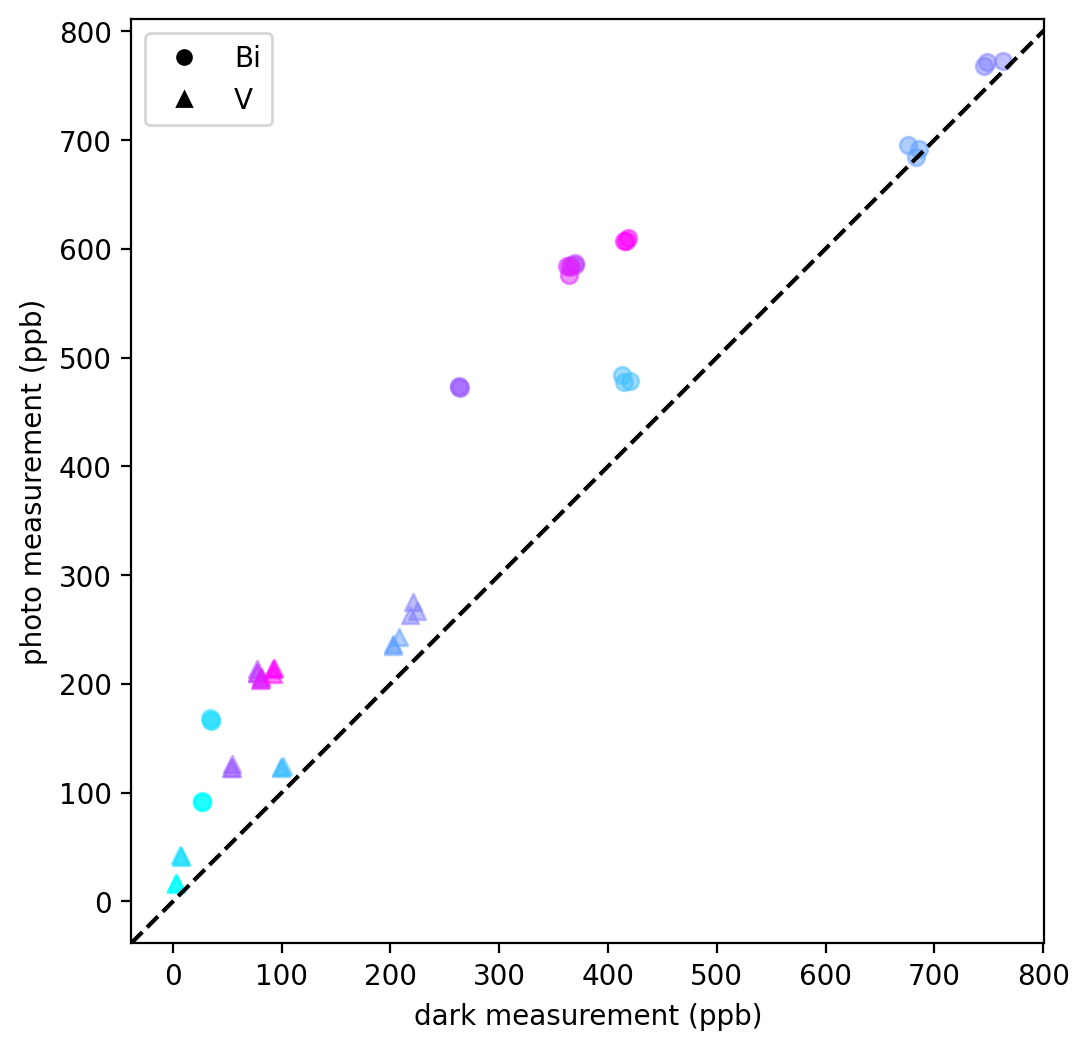

In [27]:
from matplotlib import cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

marker_map = {"Bi": "o", "V": "^"}

legend_elements = [
    Line2D([0], [0], marker=v, color='black', label=k, lw=0, markersize=5) 
    for k,v in marker_map.items()
]

from matplotlib import rcParams
rcParams["figure.figsize"] = (6, 6)
rcParams["figure.dpi"] = 200

# dark vs illum sample comparison
dvi = {"dark": 26275, "ill": 20541}
dvd = {
    el: {
        k: list(subpal.query("sample_no==@v")[f"{el}_ppb"])
        for k,v in dvi.items()
    }
    for el,_ in itups
}

cmap = cm.get_cmap('cool', len(dvd["Bi"]["dark"]))

## plot dark vs light
for el, d in dvd.items():
    for i, (d, l) in enumerate(zip(d["dark"], d["ill"])):
        plt.scatter(
            d, l, marker=marker_map[el], alpha=0.5, c = cmap(i)
        )

plt.gca().set_aspect(1.0)
plt.axline((0, 0), slope=1, c="black", ls="--")
plt.xlabel("dark measurement (ppb)")
plt.ylabel("photo measurement (ppb)")
plt.legend(handles=legend_elements)

In [28]:
subeche["action_epoch"] = subeche.action_timestamp.apply(lambda x: x.timestamp())
subsol["action_epoch"] = subsol.action_timestamp.apply(lambda x: x.timestamp())

In [29]:
""" Notes:
(conversion note: 1 ppb = 1 ug / L)
use mendeleev package to get atomic masses
"""

MASSD = {k: mendeleev.element(k).atomic_weight for k,_ in itups}

In [30]:
for k,_ in itups:
    subpal[f'{k}_mol_L'] = subpal[f'{k}_ppb'].apply(lambda x: np.array(x) * 1e-6 / MASSD[k])
    subpal[f'{k}_mol'] = subpal.apply(lambda x: x.cell_volume_ul * 1e-6 * x[f'{k}_mol_L'], axis=1)

In [31]:
subpal['Bi_comp'] = subpal.apply(lambda x: (x.Bi_mol/(x.Bi_mol + x.V_mol)).round(2), axis=1)
subpal['V_comp'] = 1 - subpal.Bi_comp
subpal['Bi_V_ratio'] = subpal.apply(lambda x: (x.Bi_mol/x.V_mol).round(2), axis=1)

In [58]:
import re

# g/cm2
oxide_densities = {
    "Bi4O7": 9.23,
    "BiVO4": 6.80,
}

def calc_oxide_amu(compstr):
    eln_strs = re.findall("([A-Z][a-z]*\d*)", compstr)
    eln_dict = {}
    metal_sum = 0
    el_ratio = {}
    for x in eln_strs:
        elns = re.findall("([A-Z][a-z]*)(\d*)", x)
        for eln in elns:
            el, n = eln
            if n == "":
                n = 1
            n = int(n)
            eln_dict[el] = n
            metal_sum += 0 if el=="O" else n
            el_ratio[el] = 1.0/n
    oxide_amu = sum([mendeleev.element(el).atomic_weight * n for el, n in eln_dict.items()])
    return oxide_amu, metal_sum, el_ratio

oxide_amus = {}
cat_ratios = {}
el_ratios = {}
for k in oxide_densities.keys():
    oxide_amu, metal_sum, el_ratio = calc_oxide_amu(k)
    oxide_amus[k] = oxide_amu
    cat_ratios[k] = 1 / metal_sum
    el_ratios[k] = el_ratio

In [41]:
oxide_amus

{'Bi4O7': 947.9146000000001, 'BiVO4': 323.9179}

In [42]:
el_ratio

{'Bi': 1.0, 'V': 1.0, 'O': 0.25}

In [47]:
xrfd = copy(subeche[["solid_label", "composition"]].drop_duplicates(["solid_label"]).reset_index(drop=True))

In [48]:
subpal = copy(subpal.merge(xrfd, on="solid_label"))
subpal["Bi_xrf"] = subpal.composition.apply(lambda d: d["Bi"])
subpal["V_xrf"] = subpal.composition.apply(lambda d: d["V"])

In [49]:
for k in ("Bi", "V"):
    subpal[f"{k}_mol_after_aliquot"] = subpal.apply(lambda x: x[f'{k}_mol_L'].mean() * (x.cell_volume_ul - x.aliquot_volume_ul) * 1e-6, axis=1)
    subpal[f"{k}_mol_in_aliquot"] = subpal.apply(lambda x: x[f'{k}_mol_L'].mean() * x.aliquot_volume_ul * 1e-6, axis=1)
    subpal[f"{k}_mol_cumulative_aliquots"] = subpal.groupby("sequence_uuid")[f"{k}_mol_in_aliquot"].cumsum()
    subpal[f"{k}_mol_cumulative_total"] = subpal[f"{k}_mol_after_aliquot"] + subpal[f"{k}_mol_cumulative_aliquots"]

In [66]:
# ICDD
# Bi4O7: 9.23 g/cm3 -- matches mp-30303
# BiVO4: 6.80 g/cm3 -- matches mp-23506

# moles of metal per cm3
rho = {
    "BiVO4": oxide_densities["BiVO4"] / (oxide_amus["BiVO4"] * el_ratios["BiVO4"]["Bi"]),
    "Bi4O7": oxide_densities["Bi4O7"] / (oxide_amus["Bi4O7"] * el_ratios["Bi4O7"]["Bi"]),
    }
alpha = 0.317

# A = V, B = Bi

subpal['BiVO4_dissolved_cm'] = subpal.apply(
    lambda x: x.Bi_mol_cumulative_total / ((1 - x.V_xrf) * (rho['BiVO4'] * alpha)),
    axis=1)

subpal['Bi4O7_coating_cm'] = subpal.apply(
    lambda x: (
        (1 / (rho['Bi4O7'] * alpha))
        * ((x.V_xrf / (1 - x.V_xrf)) * x.V_mol_cumulative_total - x.Bi_mol_cumulative_total)
    ),
    axis=1
)

subpal['BiVO4_dissolved_nm'] = subpal['BiVO4_dissolved_cm'] * 1e-2 * 1e9
subpal['Bi4O7_coating_nm'] = subpal['Bi4O7_coating_cm'] * 1e-2 * 1e9

subpal['sequence_epoch'] = subpal.sequence_timestamp.apply(lambda x: datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S.%f").timestamp())
subpal['aliquot_elapsed_s'] = subpal.aliquot_epoch - subpal.sequence_epoch

In [67]:
from datetime import datetime

<Axes: xlabel='aliquot_elapsed_s', ylabel='cell_volume_ul'>

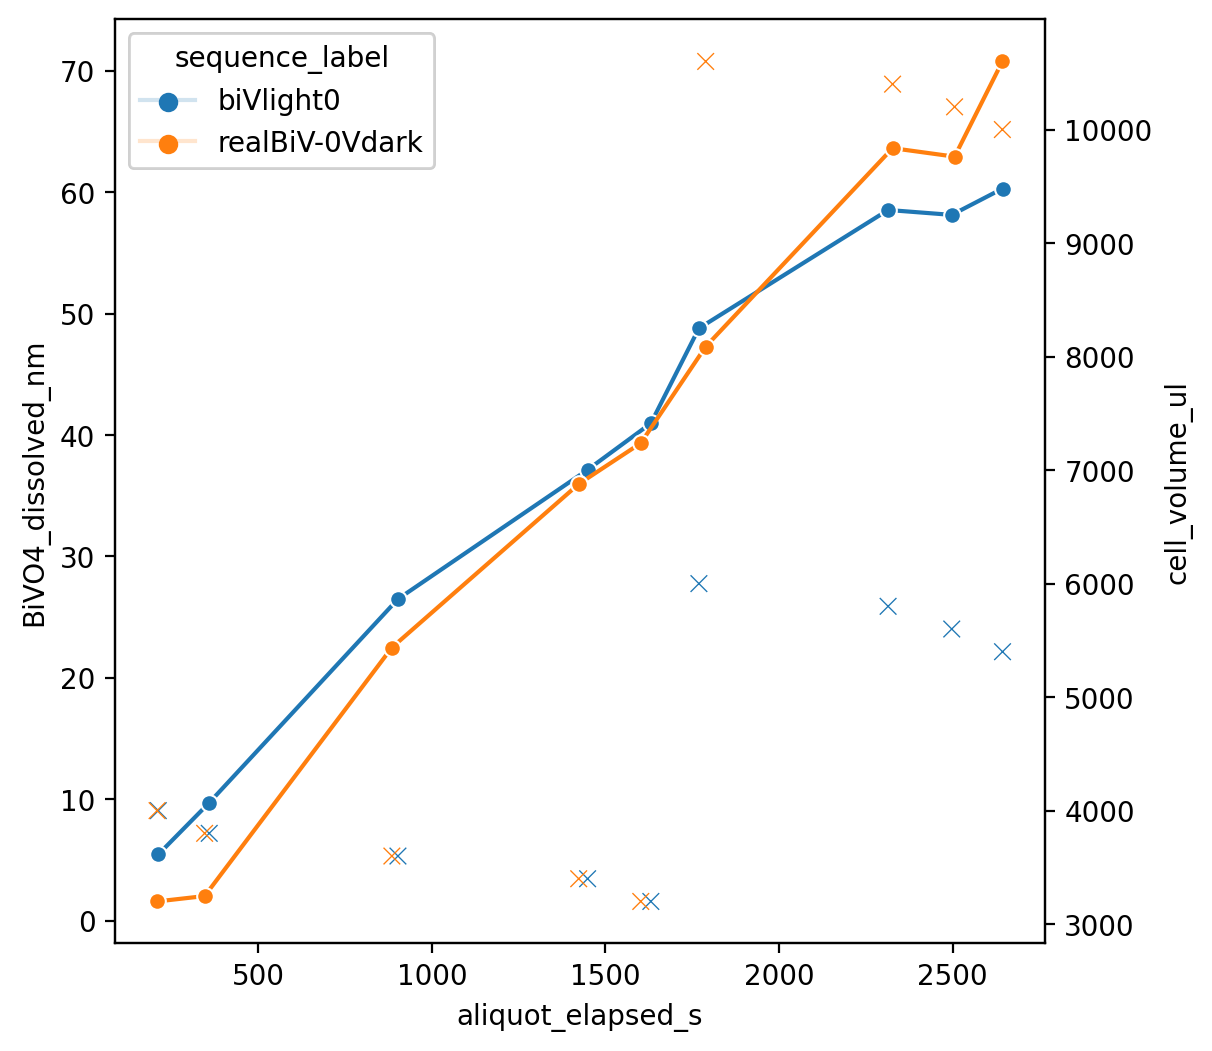

In [68]:
import seaborn as sns
sns.lineplot(
    subpal.query("sequence_label!='6058negp5naoh'"),
    x='aliquot_elapsed_s',
    y='BiVO4_dissolved_nm',
    hue='sequence_label',
    marker="o"
)
ax2 = plt.twinx()
sns.scatterplot(
    subpal.query("sequence_label!='6058negp5naoh'"),
    x='aliquot_elapsed_s',
    y='cell_volume_ul',
    hue='sequence_label',
    marker="x",
    ax=ax2
)

<Axes: xlabel='aliquot_elapsed_s', ylabel='cell_volume_ul'>

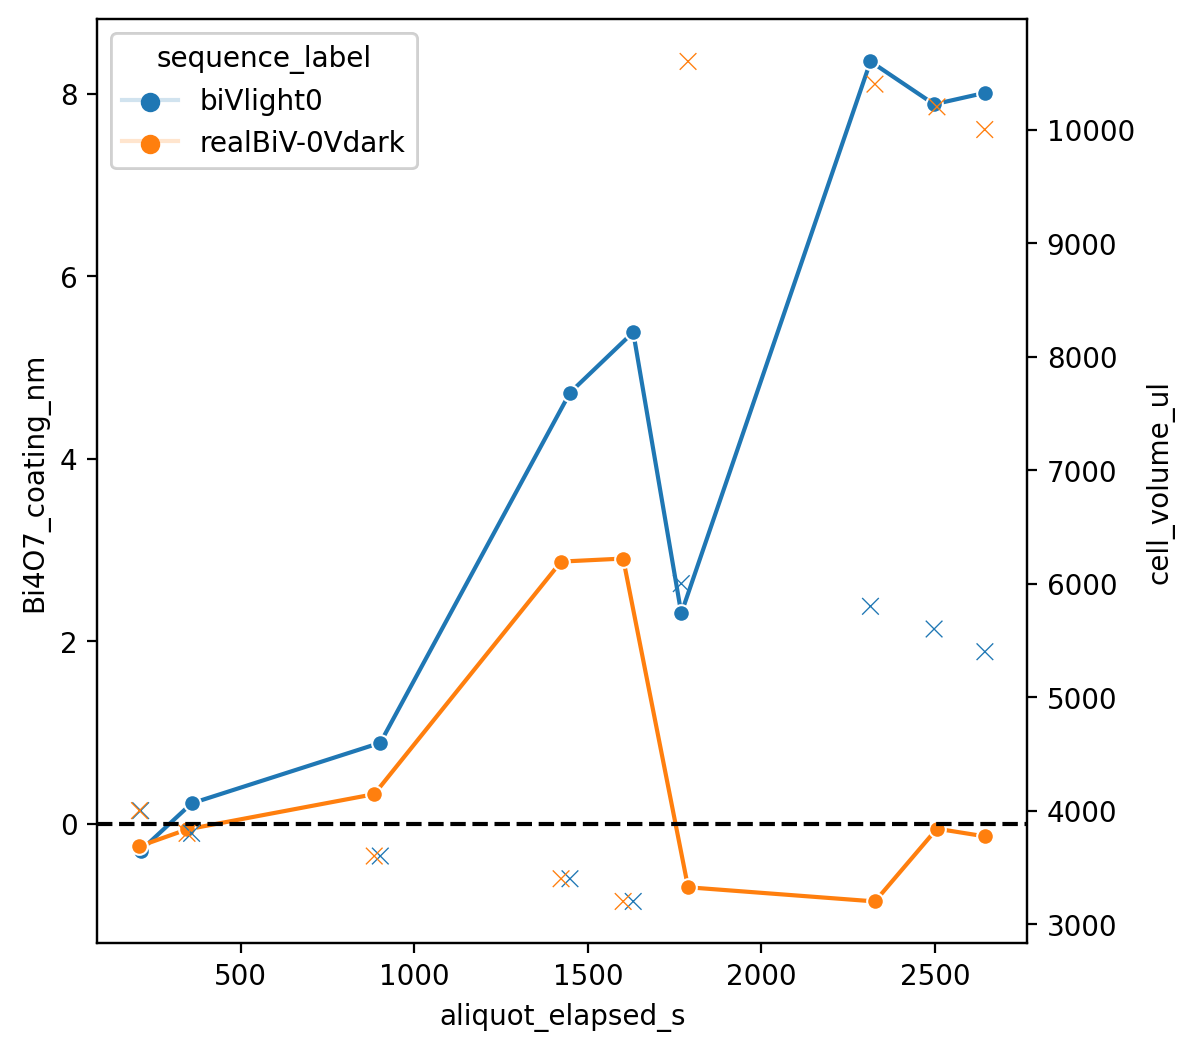

In [69]:
sns.lineplot(
    subpal.query("sequence_label!='6058negp5naoh'"),
    x='aliquot_elapsed_s',
    y='Bi4O7_coating_nm',
    hue='sequence_label',
    marker="o"
)
ax = plt.gca()
ax.axhline(y=0, c='black', ls='--')
ax2 = plt.twinx()
sns.scatterplot(
    subpal.query("sequence_label!='6058negp5naoh'"),
    x='aliquot_elapsed_s',
    y='cell_volume_ul',
    hue='sequence_label',
    marker="x",
    ax=ax2
)

<Axes: xlabel='aliquot_elapsed_s', ylabel='value'>

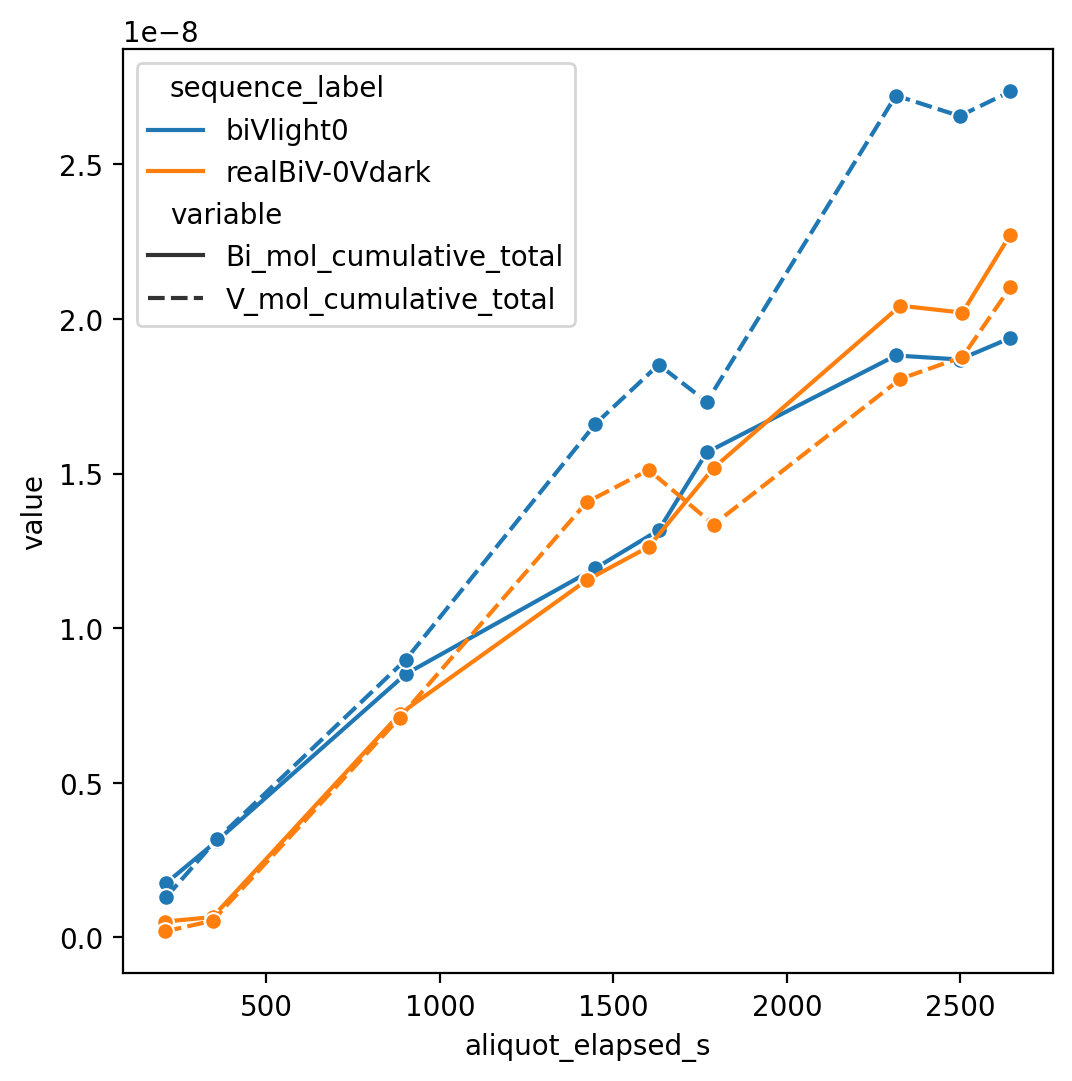

In [70]:
sns.lineplot(
    subpal.query("sequence_label!='6058negp5naoh'").melt(id_vars=["aliquot_elapsed_s", "sequence_label"], value_vars=["Bi_mol_cumulative_total", "V_mol_cumulative_total"]),
    x='aliquot_elapsed_s',
    y='value',
    hue='sequence_label',
    marker="o",
    style="variable"
)

<Axes: xlabel='aliquot_elapsed_s', ylabel='V_mol_cumulative_total'>

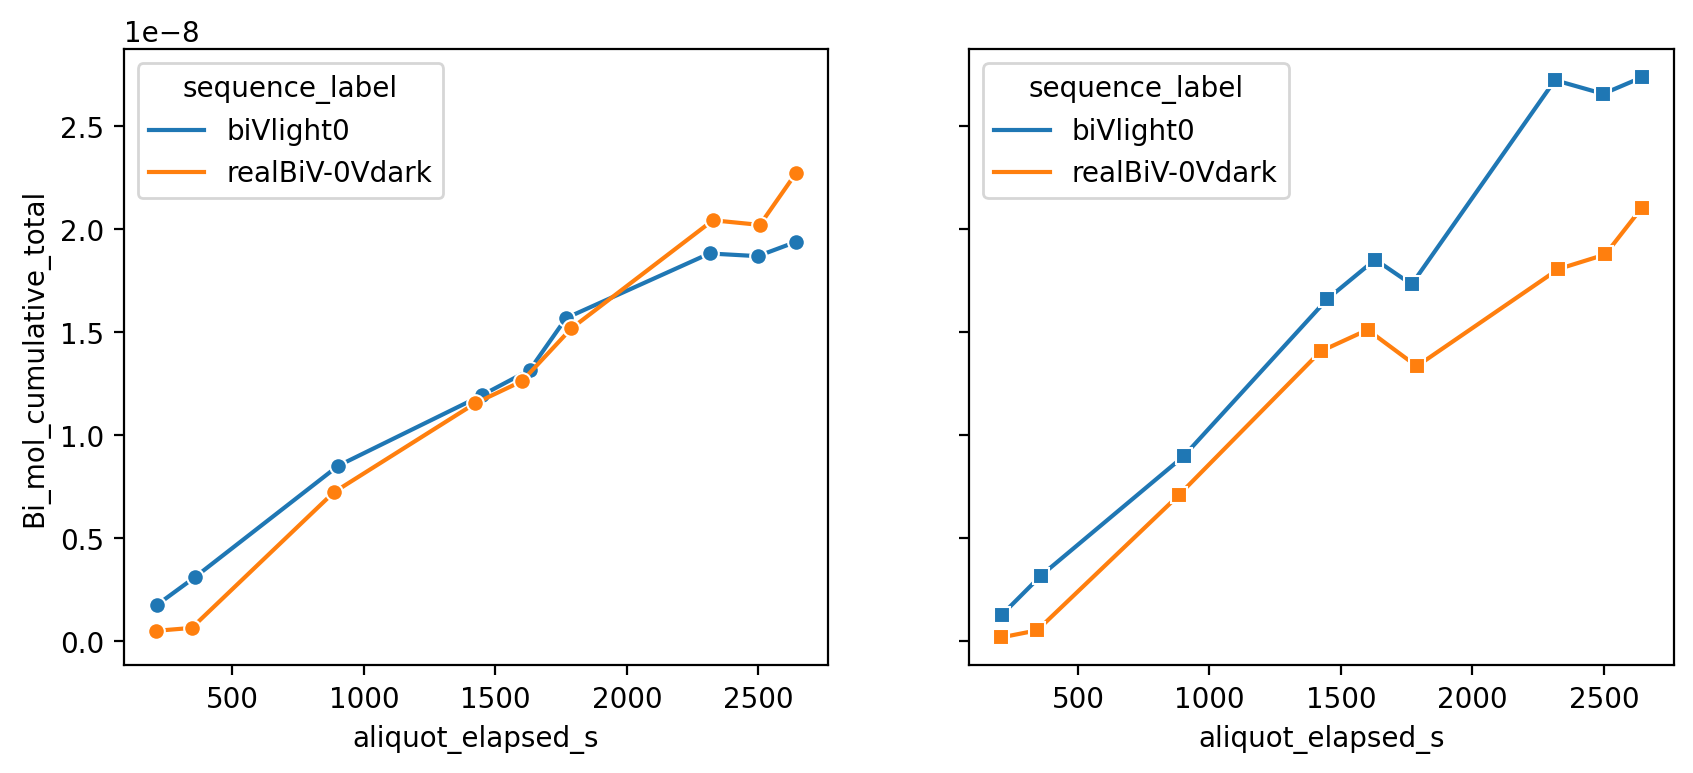

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
sns.lineplot(
    subpal.query("sequence_label!='6058negp5naoh'"),
    x='aliquot_elapsed_s',
    y='Bi_mol_cumulative_total',
    hue='sequence_label',
    marker="o",
    ax=ax[0]
)
sns.lineplot(
    subpal.query("sequence_label!='6058negp5naoh'"),
    x='aliquot_elapsed_s',
    y='V_mol_cumulative_total',
    hue='sequence_label',
    marker="s",
    ax=ax[1]
)

# ADSS-style stacked plots

In [79]:
# Note: ICPMS timestamps appear to be local, HELAO timestamps are UTC

keep_columns = [
    "sequence_uuid",
    "sequence_timestamp",
    "experiment_uuid",
    "technique_name",
    "action_name",
    "plate_id",
    "sample_no",
    "liquid_label",
]
icpms_keys = [k[0] for k in itups]
icpms_columns = [f"{k}_ppb" for k in icpms_keys]
seqs = subeche.query("sequence_label!='6058negp5naoh'").drop_duplicates("sequence_uuid").sequence_uuid

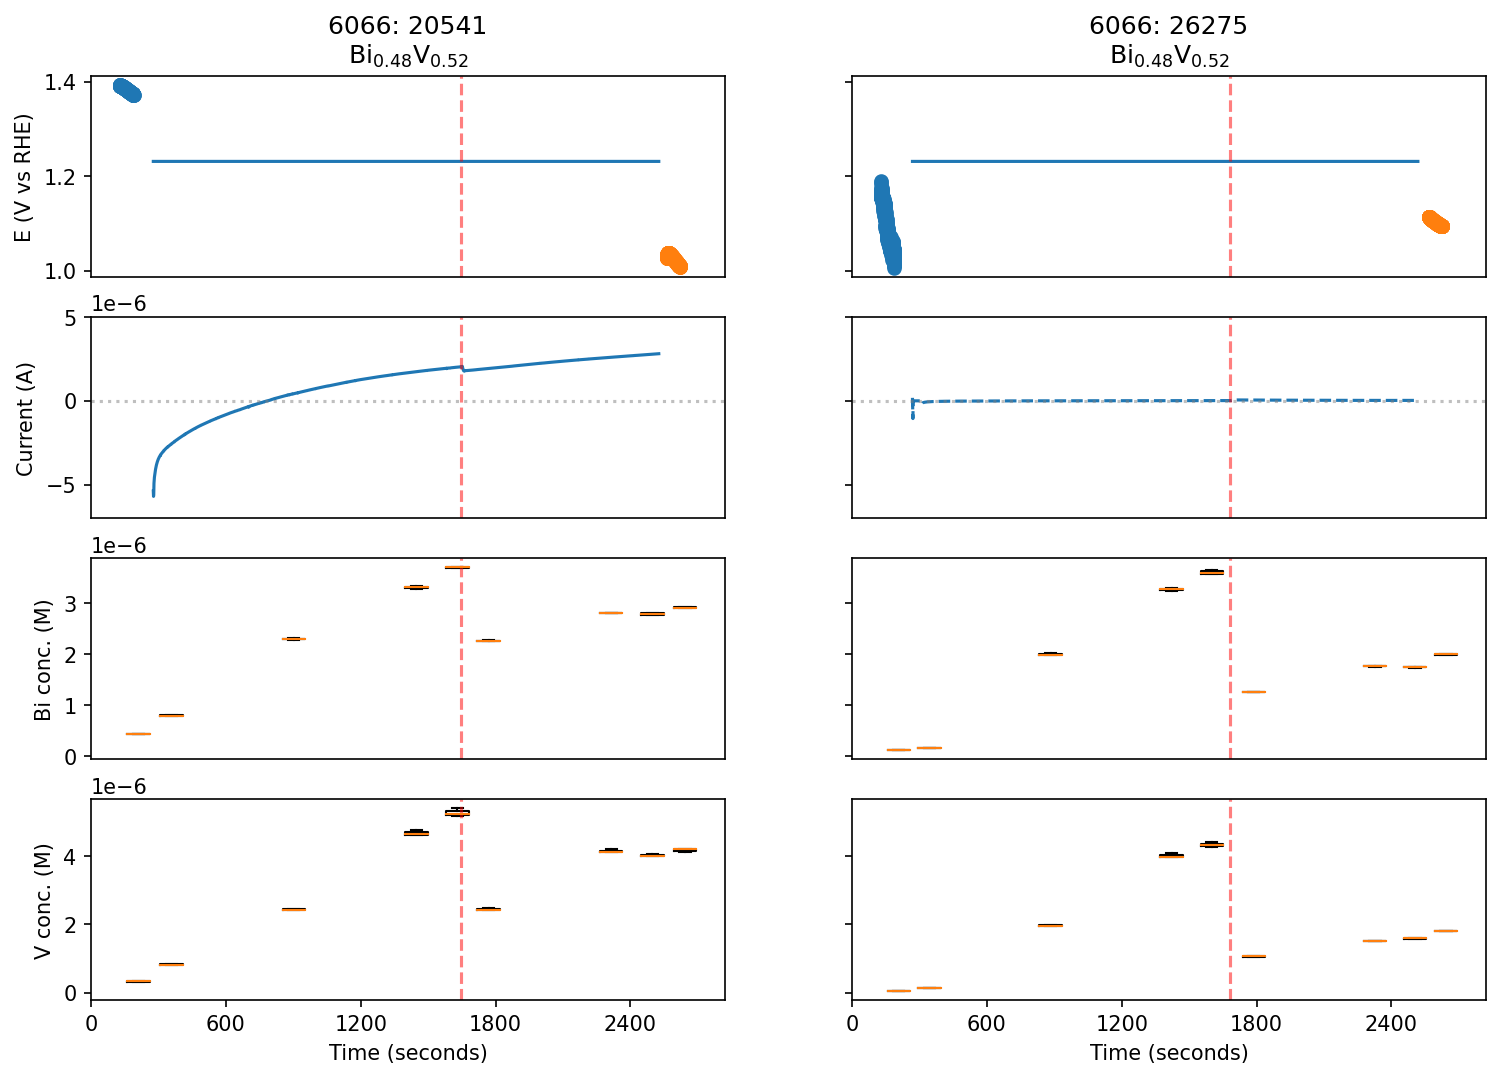

In [86]:
fig, ax = plt.subplots(
    2 + len(icpms_columns),
    len(seqs),
    sharey="row",
    sharex="col",
    figsize=(12, 8),
    dpi=150,
)

for i, suuid in enumerate(seqs):
    seche = subeche.query("sequence_uuid == @suuid")[
        keep_columns + ["action_epoch", "t_s", "I_A", "Erhe_V", "composition"]
    ]
    compstr = "".join(
        [
            f"{k}$_" + "{" + f"{v:.2f}" + "}$"
            for k, v in sorted(seche.iloc[0].composition.items())
        ]
    )
    plate_id = seche.iloc[0].plate_id
    sample_no = seche.iloc[0].sample_no
    spal = subpal.query("sequence_uuid == @suuid")[
        keep_columns
        + ["liquid_out", "aliquot_epoch", "cell_volume_ul", "aliquot_volume_ul"]
        + icpms_columns
    ]
    # row 0: potential vs time
    for _, carow in seche.query("action_name=='run_CA'").iterrows():
        ca_times = [
            (
                datetime.fromtimestamp(carow.action_epoch, tz=tz.gettz("UTC"))
                + timedelta(seconds=t)
                - carow.sequence_timestamp.tz_localize("UTC")
            ).seconds
            for t in carow.t_s
        ]
        ax[0, i].plot(ca_times, carow.Erhe_V)
    for _, ocvrow in seche.query("action_name=='run_OCV'").iterrows():
        ocv_times = [
            (
                datetime.fromtimestamp(ocvrow.action_epoch, tz=tz.gettz("UTC"))
                + timedelta(seconds=t)
                - ocvrow.sequence_timestamp.tz_localize("UTC")
            ).seconds
            for t in ocvrow.t_s
        ]
        ax[0, i].scatter(ocv_times, ocvrow.Erhe_V)
    # row 1: current vs time
    for _, carow in seche.query("action_name=='run_CA'").iterrows():
        ca_times = [
            (
                datetime.fromtimestamp(carow.action_epoch, tz=tz.gettz("UTC"))
                + timedelta(seconds=t)
                - carow.sequence_timestamp.tz_localize("UTC")
            ).seconds
            for t in carow.t_s
        ]
        ax[1, i].plot(ca_times, carow.I_A, ls="--" if i==1 else "-")
        ax[1, i].set_ylim(-7e-6, 5e-6)
        ax[1, i].axhline(y=0, c="gray", alpha=0.5, ls=":")
        # ax[1, i].set_yscale("log")
    # remaining rows: icpms ppb
    for j, col in enumerate(icpms_keys):
        moles = []
        pal_times = []
        for _, msrow in spal.iterrows():
            cell_ml = msrow.cell_volume_ul * 1e-3
            aliquot_ml = msrow.aliquot_volume_ul * 1e-3
            moles_in_cell = cell_ml * 1e-3 * np.array(msrow[f"{col}_ppb"]) * 1e-6 / MASSD[col]
            molarity = np.array(msrow[f"{col}_ppb"]) * 1e-6 / MASSD[col]
            # moles.append(moles_in_cell)
            moles.append(molarity)
            pal_times.append(
                (
                    datetime.fromtimestamp(
                        msrow.aliquot_epoch, tz=tz.gettz("Pacific / Los Angeles")
                    ).replace(tzinfo=tz.gettz("UTC"))
                    - msrow.sequence_timestamp.tz_localize("UTC")
                ).seconds
            )
        # ax[2 + j, i].scatter(times, moles)
        ax[2 + j, i].boxplot(moles, positions=pal_times, widths=100, flierprops={'markersize': 1})
        if i == 0:
            # ax[2 + j, i].set_ylabel(f"{col} in electrolyte\n(moles)")
            ax[2 + j, i].set_ylabel(f"{col} conc. (M)")
    if i == 0:
        ax[0, i].set_ylabel("E (V vs RHE)")
        ax[1, i].set_ylabel("Current (A)")
    for ri in range(1 + len(icpms_keys)):
        ax[ri, i].xaxis.set_visible(False)
    ax[0, i].set_title(f"{plate_id}: {sample_no}\n{compstr}")
    ax[len(icpms_keys) + 1, i].set_xlabel("Time (seconds)")
    # ax[len(icpms_keys) + 1, i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    # ax[len(icpms_keys), i].xaxis.set_major_locator(mdates.MinuteLocator(interval=4))
    ssol = subsol.query("sequence_uuid == @suuid")[["action_epoch"]]
    if ssol.shape[0] > 0:
        infuse_epoch = ssol.iloc[0].action_epoch
        for rowi in range(2 + len(icpms_columns)):
            ax[rowi, i].axvline(
                x=(
                    datetime.fromtimestamp(infuse_epoch, tz=tz.gettz("UTC"))
                    - carow.sequence_timestamp.tz_localize("UTC")
                ).seconds,
                ls="--",
                c="red",
                alpha=0.5,
                label="inject"
            )
            # ax[rowi, i].legend()
    last_ocv_time = max(ocv_times)
    xticks = np.arange(0, last_ocv_time+100, 600)
    ax[1 + len(icpms_columns), i].set_xticks(xticks, [str(x) for x in xticks])